# Import Libraries

Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

# Obtain Data

Read clothing sales data csv into pandas df

In [2]:
df = pd.read_excel('Data/clothing_sales.xls', header=10)
df.columns = ['Period', 'Sales']
df.head()

,Period,Sales
0,1992-01-01,4852
1,1992-02-01,5159
2,1992-03-01,6024
3,1992-04-01,6682
4,1992-05-01,6768


Use df period column to create month and year columns

In [3]:
df['Month'] = df['Period'].apply(lambda x: str(x).split('-')[1])
df['Year'] = df['Period'].apply(lambda x: str(x).split('-')[0])
df.head()

,Period,Sales,Month,Year
0,1992-01-01,4852,01,1992
1,1992-02-01,5159,02,1992
2,1992-03-01,6024,03,1992
3,1992-04-01,6682,04,1992
4,1992-05-01,6768,05,1992


Read weather data into pandas

In [4]:
weather_df = pd.read_csv('Data/weather.csv')
weather_df['Date'] = pd.to_datetime(weather_df['Date'], format='%Y-%m-%d')
weather_df.head()

,Month,Year,Warm Days,Cold Days,Unfavorable Days,Date
0,1,1992,19.81%,0.00%,19.81,1992-01-01
1,1,1993,3.74%,0.00%,3.74,1993-01-01
2,1,1994,8.55%,13.84%,8.55,1994-01-01
3,1,1995,5.27%,0.00%,5.27,1995-01-01
4,1,1996,2.60%,0.00%,2.60,1996-01-01


Merge clothing sales df and weather df

In [5]:
df = pd.merge(df, weather_df[['Unfavorable Days', 'Date']], left_on='Period', right_on='Date')
df.drop(columns='Date', inplace=True)
df.head()

,Period,Sales,Month,Year,Unfavorable Days
0,1992-01-01,4852,01,1992,19.81
1,1992-02-01,5159,02,1992,50.79
2,1992-03-01,6024,03,1992,0.00
3,1992-04-01,6682,04,1992,0.38
4,1992-05-01,6768,05,1992,15.96


# Scrub Data

Confirm no missing data or incorrect datatypes in df

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336 entries, 0 to 335
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Period            336 non-null    datetime64[ns]
 1   Sales             336 non-null    int64         
 2   Month             336 non-null    object        
 3   Year              336 non-null    object        
 4   Unfavorable Days  336 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 15.8+ KB


Remove covid outlier periods after 12/2019 from df 

        Period  Sales Month  Year  Unfavorable Days
331 2019-08-01  16708    08  2019              0.63
332 2019-09-01  14157    09  2019             60.87
333 2019-10-01  15773    10  2019             11.72
334 2019-11-01  18592    11  2019              5.28
335 2019-12-01  23598    12  2019             14.16


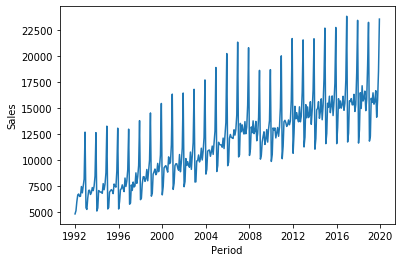

In [7]:
df = df[df['Period']<'2020-01-01']
print(df.tail())
fig, ax = plt.subplots()
sns.lineplot(x='Period', y='Sales', data=df, ax=ax)

# Explore Data

Calculate mean clothing retail sales

In [28]:
df['Sales'].values.mean()

11837.994047619048

Calculate clothing retail sales standard deviation

In [29]:
df['Sales'].values.std()

3888.5938232970043

Plot monthly retail clothing sales from 1/1992 to 12/2019

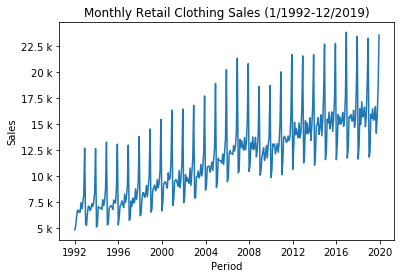

In [8]:
fig, ax = plt.subplots()
sns.lineplot(x='Period', y='Sales', data=df, ax=ax)
ax.set_title('Monthly Retail Clothing Sales (1/1992-12/2019)')
ax.yaxis.set_major_formatter(matplotlib.ticker.EngFormatter())

Plot total retail clothing sales by year

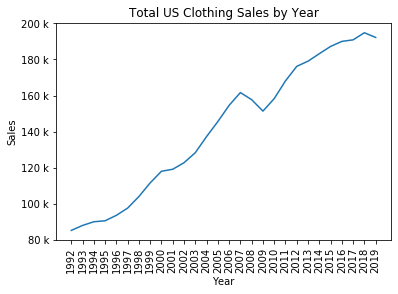

In [9]:
annual_df = df.groupby('Year').sum().reset_index()
fig, ax = plt.subplots()
sns.lineplot(x='Year', y='Sales', data=annual_df, ax=ax)
ax.set_xticklabels(annual_df['Year'], rotation=90)
ax.set_title('Total US Clothing Sales by Year')
ax.yaxis.set_major_formatter(matplotlib.ticker.EngFormatter())

Plot average retail clothing sales by month

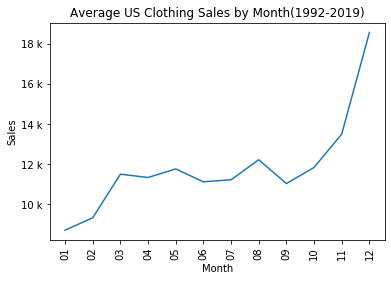

In [10]:
monthly_df = df.groupby('Month').mean().reset_index()
fig, ax = plt.subplots()
sns.lineplot(x='Month', y='Sales', data=monthly_df, ax=ax)
ax.set_xticklabels(monthly_df['Month'], rotation=90)
ax.set_title('Average US Clothing Sales by Month(1992-2019)')
ax.yaxis.set_major_formatter(matplotlib.ticker.EngFormatter())

Create df column for differenced monthly sales

In [11]:
df['Differenced Sales'] = df[['Sales']].diff(periods=12)
df.iloc[10:15]

,Period,Sales,Month,Year,Unfavorable Days,Differenced Sales
10,1992-11-01,8201,11,1992,0.45,NaN
11,1992-12-01,12721,12,1992,0.00,NaN
12,1993-01-01,5439,01,1993,3.74,587.0
13,1993-02-01,5284,02,1993,0.00,125.0
14,1993-03-01,6349,03,1993,0.00,325.0


Plot differenced time series data

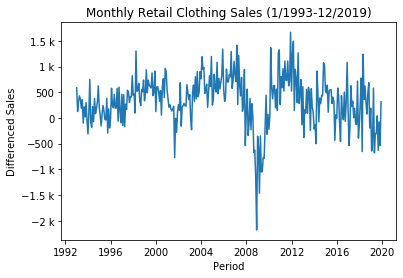

In [12]:
fig, ax = plt.subplots()
sns.lineplot(x='Period', y='Differenced Sales', data=df.iloc[12:], ax=ax)
ax.set_title('Monthly Retail Clothing Sales (1/1993-12/2019)')
ax.yaxis.set_major_formatter(matplotlib.ticker.EngFormatter())

# Model Data

In [13]:
adfuller(df['Differenced Sales'][12:])

(-3.4207196371269055,
 0.010272496366189526,
 15,
 308,
 {'1%': -3.45176116018037,
  '5%': -2.870970093607691,
  '10%': -2.571794416006072},
 4504.033564224299)

Plot acf function

Text(0, 0.5, 'Correlation')

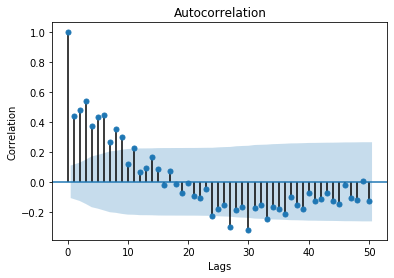

In [14]:
fig, ax = plt.subplots()
plot_acf(df['Differenced Sales'][12:], alpha=.05, lags = 50, ax=ax)
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')

Plot pacf function

Text(0, 0.5, 'Correlation')

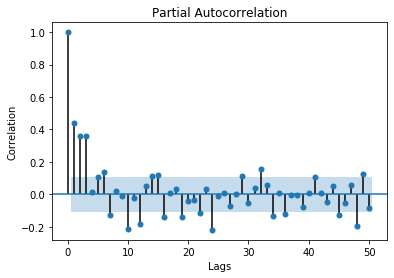

In [15]:
fig, ax = plt.subplots()
plot_pacf(df['Differenced Sales'][12:], alpha=.05, lags = 50, ax=ax)
ax.set_xlabel('Lags')
ax.set_ylabel('Correlation')

Create train and test series

In [16]:
train_series = df['Sales'].values[:-48]
val_series = df['Sales'].values[-48:]

Build baseline persistence model

In [17]:
train_predictions = train_series[0:-1]
train_actuals = train_series[1:]
val_predictions = val_series[0:-1]
val_actuals = val_series[1:]
print('Train RMSE:', np.sqrt(mean_squared_error(train_actuals, train_predictions)))
print('Train MAE:', mean_absolute_error(train_actuals, train_predictions))
print('Validation RMSE:', np.sqrt(mean_squared_error(val_actuals, val_predictions)))
print('Validation MAE:', mean_absolute_error(val_actuals, val_predictions))

Train RMSE: 3170.085054201398
Train MAE: 1874.191637630662
Validation RMSE: 3689.415986189269
Validation MAE: 2362.659574468085


Build baseline mean predicting model

In [18]:
train_mean_predictions = [train_series.mean()]*288
train_mean_actuals = train_series
val_mean_predictions = val_series
val_mean_actuals = [train_series.mean()]*48
print('Train RMSE:', np.sqrt(mean_squared_error(train_mean_actuals, train_mean_predictions)))
print('Train MAE:', mean_absolute_error(train_mean_actuals, train_mean_predictions))
print('Validation RMSE:', np.sqrt(mean_squared_error(val_mean_actuals, val_mean_predictions)))
print('Validation MAE:', mean_absolute_error(val_mean_actuals, val_mean_predictions))

Train RMSE: 3598.0785877842536
Train MAE: 2916.690248842593
Validation RMSE: 5614.7419498698655
Validation MAE: 4845.562499999999


Build SARIMA model

In [78]:
sarima = SARIMAX(train_series, order = (5,0,4), seasonal_order = (1,1,1,12))
sarima_model = sarima.fit()
print(sarima_model.summary())
print(sarima_model.params)

/Users/blantj/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/blantj/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/blantj/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  288
Model:             SARIMAX(5, 0, 4)x(1, 1, [1], 12)   Log Likelihood               -2026.327
Date:                              Sat, 05 Dec 2020   AIC                           4076.654
Time:                                      22:37:09   BIC                           4120.099
Sample:                                           0   HQIC                          4094.088
                                              - 288                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8815      0.252      3.503      0.000       0.388       1.375
ar.L2          0.16

Evaluate SARIMA model

In [79]:
val_pred_sarima = sarima_model.forecast(steps=48)
print('Validation RMSE:', np.sqrt(mean_squared_error(val_series, val_pred_sarima)))
print('Validation MAE:', mean_absolute_error(val_series, val_pred_sarima))

Validation RMSE: 395.1858822218552
Validation MAE: 304.01580091802276


Plot sarima predicted values vs. actuals

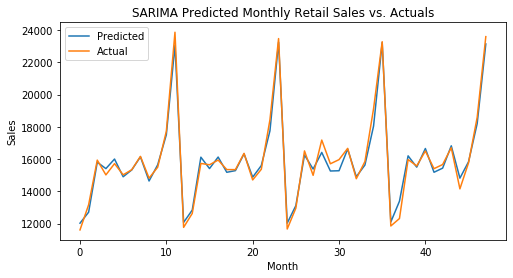

In [92]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(val_pred_sarima)
ax.plot(val_series)
ax.set_title('SARIMA Predicted Monthly Retail Sales vs. Actuals')
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.legend(['Predicted', 'Actual'], loc='upper left')

Train test split exogenous variable

In [22]:
train_exog_series = df['Unfavorable Days'].values[:-48]
val_exog_series = df['Unfavorable Days'].values[-48:]

Build SARIMAX model with weather exogenous variable

In [68]:
sarimax = SARIMAX(train_series, order = (5,0,4), seasonal_order = (1,1,1,12), exog = train_exog_series)
sarimax_model = sarimax.fit()
print(sarimax_model.summary())
print(sarimax_model.params)

/Users/blantj/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/blantj/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  288
Model:             SARIMAX(5, 0, 4)x(1, 1, [1], 12)   Log Likelihood               -2023.428
Date:                              Sat, 05 Dec 2020   AIC                           4072.856
Time:                                      22:35:14   BIC                           4119.921
Sample:                                           0   HQIC                          4091.742
                                              - 288                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -3.0590      1.344     -2.277      0.023      -5.692      -0.426
ar.L1          0.73

/Users/blantj/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Evaluate sarimax model

In [69]:
val_pred_sarimax = sarimax_model.forecast(steps=48, exog=val_exog_series)
print('Validation RMSE:', np.sqrt(mean_squared_error(val_series, val_pred_sarimax)))
print('Validation MAE:', mean_absolute_error(val_series, val_pred_sarimax))

Validation RMSE: 393.6236434523548
Validation MAE: 293.63671406588816


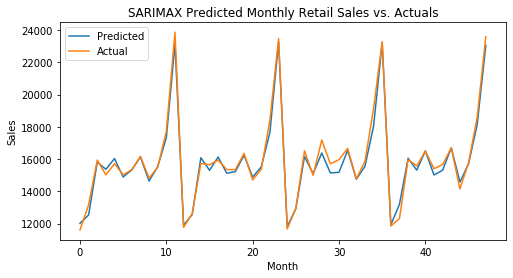

In [94]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(val_pred_sarimax)
ax.plot(val_series)
ax.set_title('SARIMAX Predicted Monthly Retail Sales vs. Actuals')
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.legend(['Predicted', 'Actual'], loc='upper left')